<a href="https://colab.research.google.com/github/christam96/VinBigData-Abnormalities-Detection/blob/master/Exploratory%20Data%20Analysis/EDA_3parts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [x] Plotting the distribution of locations of each labeled rectangle. So, let's say "0 - Aortic enlargement" would have a 2D plot, end every other class would have its plot. The goal of this would be to discover if a class tends to appear at the same spot.
- [x] Plot the distribution of average brightness of the dataset's images, this would show if images have more or less the same level of brightness (how diverse images are)
- [x] Table where rows/columns are classes, and each cell contains the number of times 2 classes appear together on image. This would show if some classes tend to appear together or no.

# Part 1

## link kaggle to colab, download train.csv

In [3]:
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()

!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json


In [4]:
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train.csv

  0% 0.00/1.79M [00:00<?, ?B/s]
100% 1.79M/1.79M [00:00<00:00, 151MB/s]


In [5]:
!unzip train.csv.zip
!rm train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


## load .csv file

In [6]:
import pandas as pd

train_df = pd.read_csv("train.csv")
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


### calculate number of radiologists per each image

In [ ]:
grouped = train_df.groupby(["image_id","rad_id"])
gr_c = grouped.count()
gr_c = gr_c.index.to_list()
gr_c = pd.DataFrame(gr_c, columns =["0","1"]) 
set(gr_c.groupby("0").count().loc[:,"1"].to_numpy())

{3}

## install pydicom, download image in order to get  the shape of it

In [7]:
!pip install -q pydicom

     |████████████████████████████████| 1.9MB 13.4MB/s 


In [8]:
import pydicom as dicom

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train/fe620114981e611e4e92f017dafc254f.dicom
!unzip fe620114981e611e4e92f017dafc254f.dicom.zip
!rm fe620114981e611e4e92f017dafc254f.dicom.zip  #ba68c12f2141bba79d9c29322c2c295a max

 77% 11.0M/14.3M [00:00<00:00, 112MB/s]
100% 14.3M/14.3M [00:00<00:00, 91.0MB/s]
Archive:  fe620114981e611e4e92f017dafc254f.dicom.zip
replace fe620114981e611e4e92f017dafc254f.dicom? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fe620114981e611e4e92f017dafc254f.dicom  


In [ ]:
ds=dicom.read_file('fe620114981e611e4e92f017dafc254f.dicom')
img = ds.pixel_array
img = ((img / (2**16 - 1)) * 255).astype("uint8")
print(img.shape)
imShape = (3500, 3500)

NameError: ignored

## define functions for distribution plotting

In [ ]:
def getCenterOfRectangle(df, class_id):
  class_i = (df.class_id == class_id)
  class_i = df.loc[class_i] 
  class_i = class_i.loc[:,["x_min","y_min","x_max","y_max"]]
  class_i = pd.concat([(class_i["y_min"] + class_i["y_max"]) / 2, (class_i["x_min"] + class_i["x_max"]) / 2],axis=1).astype("int16")
  class_i.columns = ["y_c","x_c"]
  return class_i

In [ ]:
def accumulatePosArr(centArr, imShape, verbose=False):
  # define accumulator array 
  acc_pos_i = np.zeros([3500,3500],dtype=int)
  class_i = np.array(centArr)
  a = tuple(class_i.T[:,:10].tolist())
  # accumulate acc_pos_i: add +1 to the cells stored in class_i
  np.add.at(acc_pos_i,tuple(class_i.T.tolist()),1)
  if verbose:
    print("Sum of all values in acc_pos_i before resizing: {}".format(np.sum(acc_pos_i)))
    print("Maximum value in acc_pos_i before resizing: {}".format(np.amax(acc_pos_i)))
    print("Shape of accumulator: {}".format(acc_pos_i.shape))
  return acc_pos_i

In [ ]:
def scaleDownPosArr(posArr, factor, appearsAtLeastOnce=False, verbose=False):
  posArr = np.add.reduceat(np.add.reduceat(posArr, np.arange(0, posArr.shape[0], factor), axis=0),
                                        np.arange(0, posArr.shape[1], factor), axis=1)
  if appearsAtLeastOnce:
    posArr = posArr > 0  
  # min-max scaling
  posArr = (posArr / np.amax(posArr) * 255).astype("uint8")
  if verbose:
    print("Sum of all values in acc_pos_i after resizing: {}".format(np.sum(acc_pos_i)))
    print("Maximum value in acc_pos_i after resizing: {}".format(np.amax(acc_pos_i)))
    print("New shape of accumulator arr: {}".format(acc_pos_i.shape))
  return posArr

In [ ]:
def calculateMeanAndStd(centArr, factor):
  import math as m
  mean = np.average(centArr, axis=0)
  centArr = np.array(centArr)
  distances = [m.sqrt((val[0] - mean[0])**2 + (val[1] - mean[1])**2) for i, val in enumerate(centArr)]
  return mean/factor, np.average(distances)/factor

## plot distribution

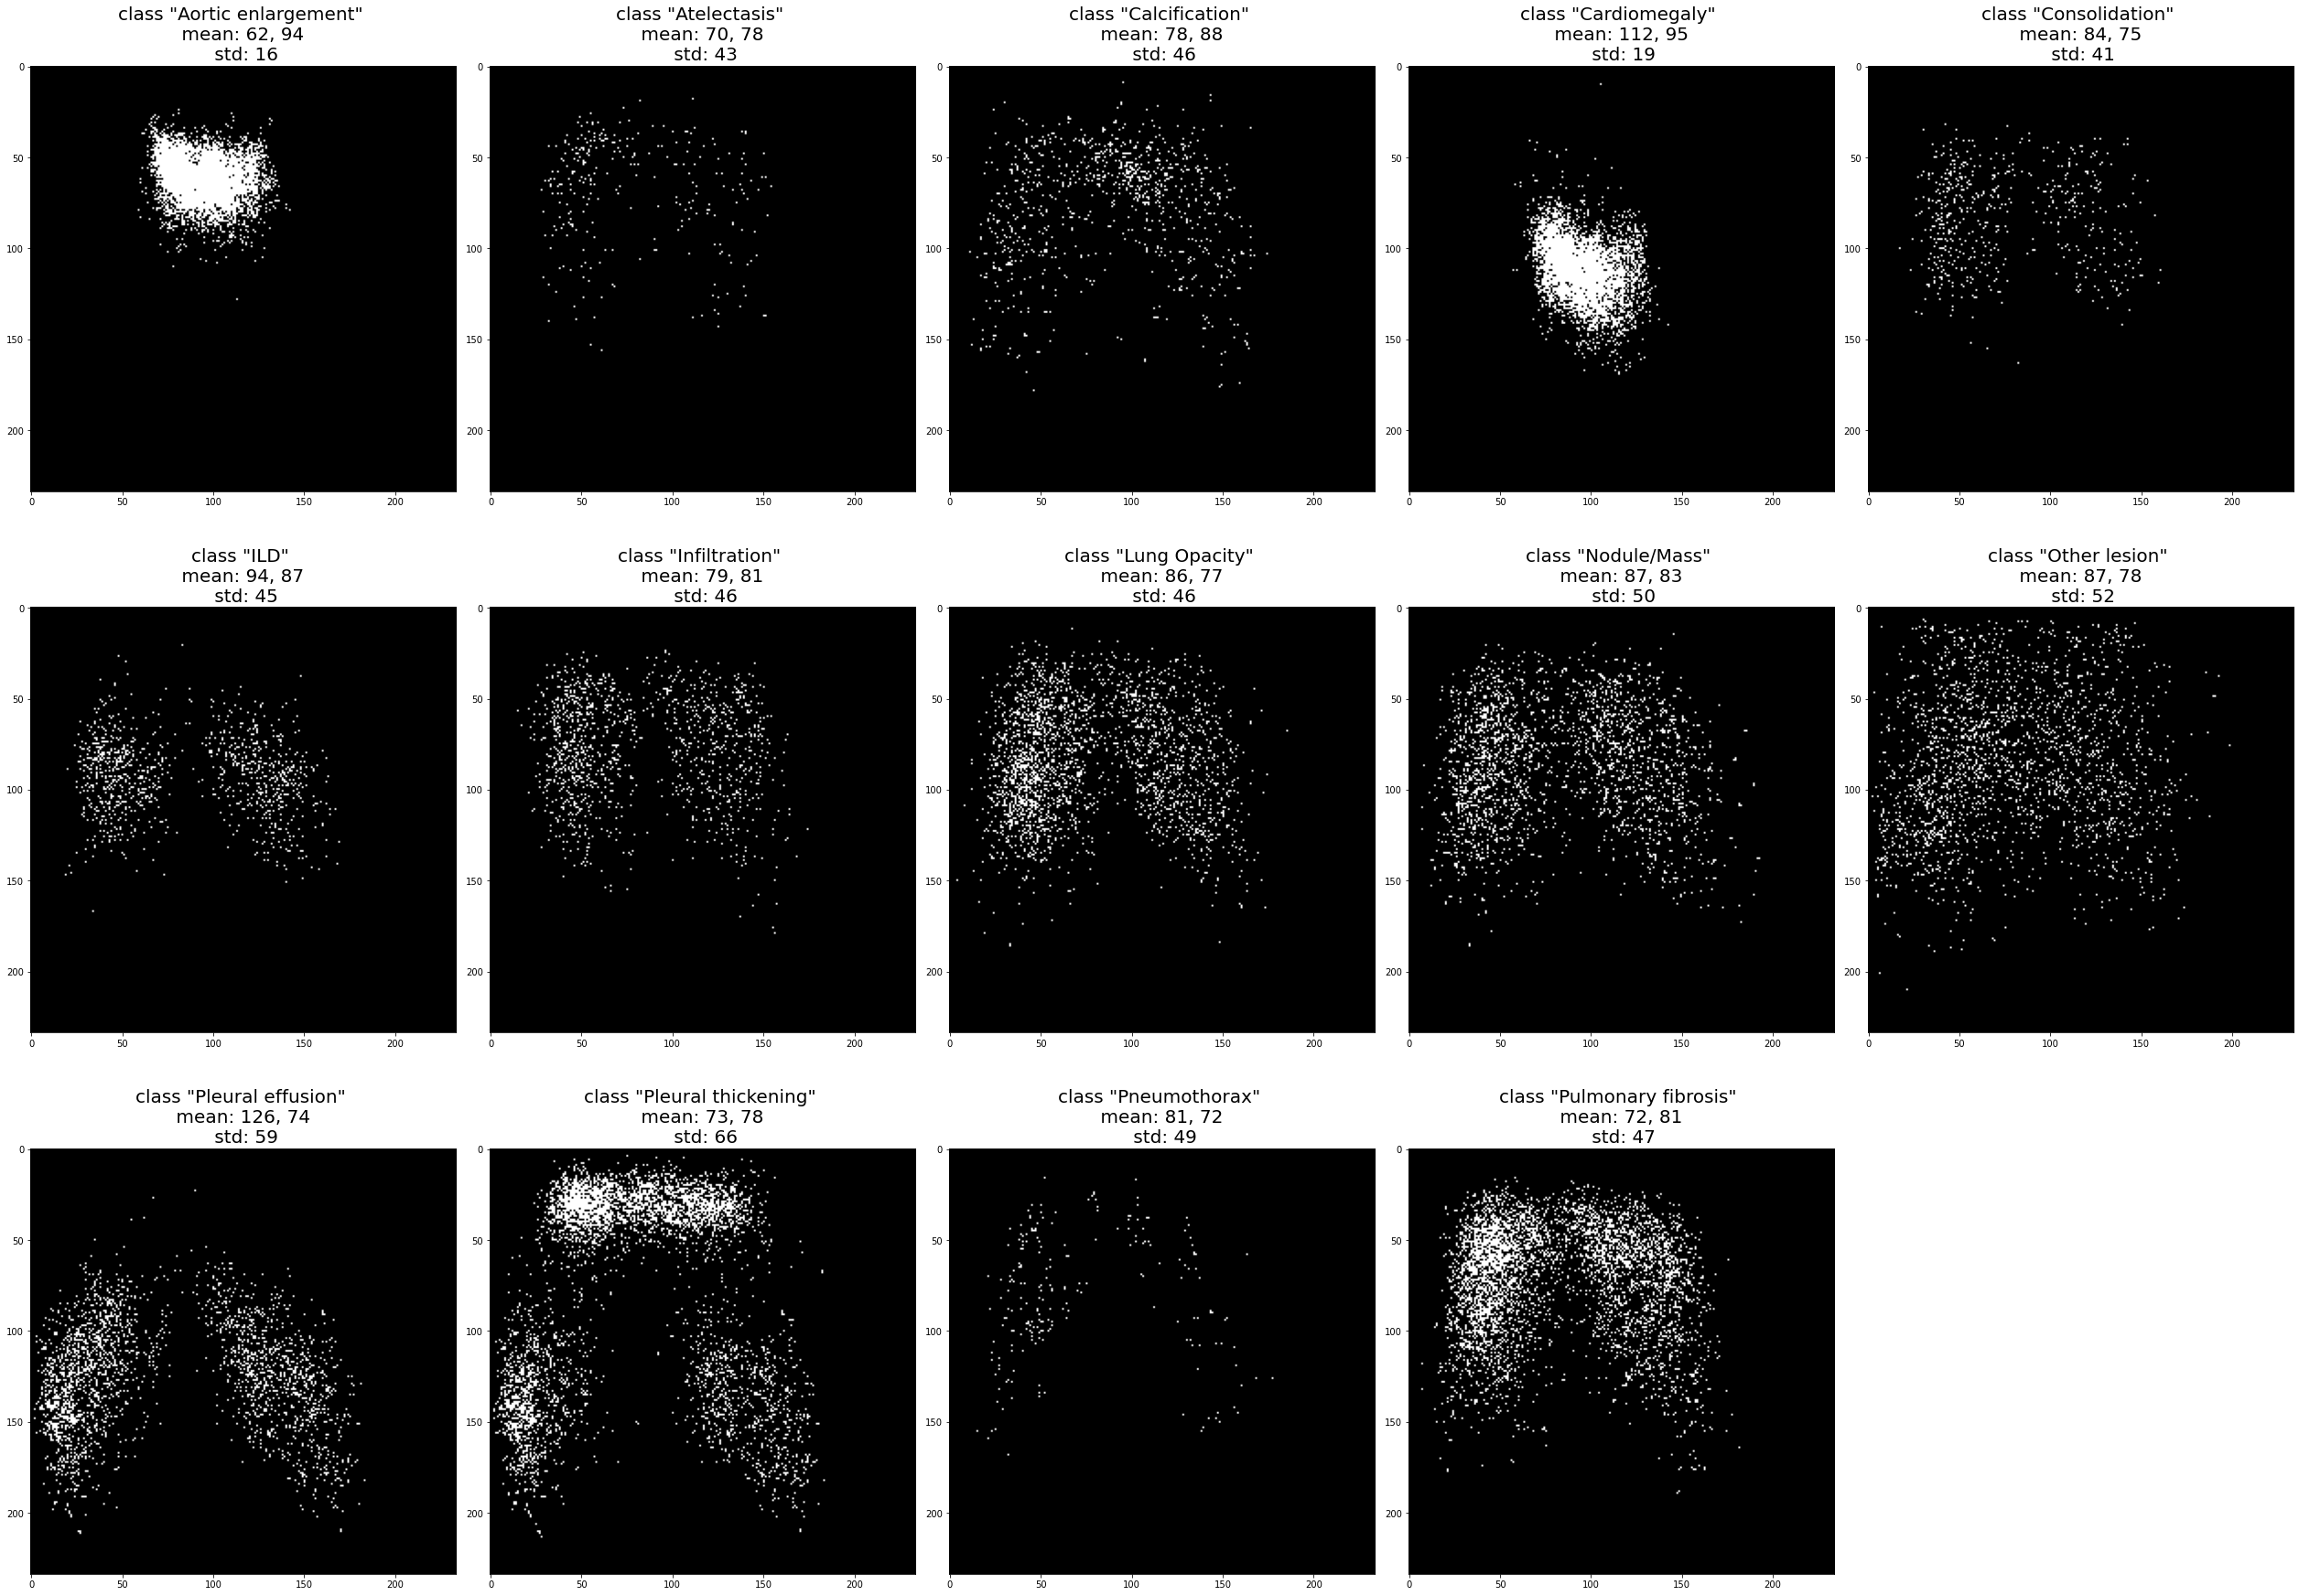

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

imShape = (3500, 3500)
h, w = (3, 5)
fig, axes = plt.subplots(h,w,figsize=(35,25))
number_of_classes = len(set(train_df.class_id)) - 1
factor = 15
labels = ["Aortic enlargement","Atelectasis","Calcification","Cardiomegaly","Consolidation",\
          "ILD","Infiltration","Lung Opacity","Nodule/Mass","Other lesion","Pleural effusion",\
          "Pleural thickening","Pneumothorax","Pulmonary fibrosis"]
for class_id in range(number_of_classes):
  centArr = getCenterOfRectangle(train_df, class_id)
  mean, std = calculateMeanAndStd(centArr, factor)
  posArr = accumulatePosArr(centArr,imShape)
  posArr = scaleDownPosArr(posArr, factor, True)
  #print(class_id // w, class_id % w)
  i, j = (class_id // w, class_id % w)
  axes[i, j].imshow(posArr, cmap = "gray")
  axes[i, j].set_title("class \"{}\" \n mean: {:.0f}, {:.0f} \n std: {:.0f}".format(labels[class_id],\
                                                      mean[0],mean[1],std),fontsize=20)
fig.delaxes(axes[-1,-1])
fig.tight_layout()
fig.savefig("bounding_box_distr.png")

# Part 2

## Mount gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Append arrays with window/image means and stds

In [ ]:
import numpy as np

corrupted_imgs = []
visited_imgs = []
number_of_pixels = []
photom_interpritation = []
patient_gender = []
bits_general = []
means_general = []
stds_general = []
means = [[] for _ in range(15)]
stds = [[] for _ in range(15)]
unique_imgs = train_df.image_id.unique()

max_num_of_imgs_per_class = 200
grouped_df = train_df.groupby("class_id")
for class_name, group_df in grouped_df:
  for img_num, img_name in enumerate(group_df.image_id):
    if (img_num >= max_num_of_imgs_per_class):
      break;
    print("Class_name: {}, img_num: {}, img_name: {}".format(class_name, img_num, img_name))
    ds=dicom.read_file("/content/drive/MyDrive/VinBigData/train_data/"+img_name+".dicom")
    try:
      highestVal = ds.BitsStored
      img = ds.pixel_array
      img = ((img / (2**highestVal - 1)) * 255).astype("uint8")
      if (img_name not in visited_imgs):
        visited_imgs.append(img_name)
        means_general.append(np.mean(img))
        stds_general.append(np.std(img))
        bits_general.append(highestVal)
        patient_gender.append(ds.PatientSex)
        photom_interpritation.append(ds.PhotometricInterpretation)
        number_of_pixels.append(ds.Columns * ds.Rows)
      if (class_name == 14):
        means[14].append(np.mean(img))
        stds[14].append(np.std(img))
      else:
        j_min= int(group_df.x_min.iloc[img_num])
        i_min= int(group_df.y_min.iloc[img_num])
        j_max= int(group_df.x_max.iloc[img_num])
        i_max= int(group_df.y_max.iloc[img_num])
        mean = np.mean(img[i_min:i_max, j_min:j_max])
        std = np.std(img[i_min:i_max, j_min:j_max])
        means[class_name].append(mean)
        stds[class_name].append(std)  
    except:
      print("Exception occurred " + "="*20)
      corrupted_imgs.append(img_name)

## Create a df table for storing means and stds

In [ ]:
image_eda_table = np.zeros((15,5))
for class_id in range(15):
  image_eda_table[class_id,0] = class_id
  image_eda_table[class_id,1] = np.mean(means[class_id])
  image_eda_table[class_id,2] = np.std(means[class_id])
  image_eda_table[class_id,3] = np.mean(stds[class_id])
  image_eda_table[class_id,4] = np.std(stds[class_id])
image_eda_table = pd.DataFrame(image_eda_table, columns=["class_id","mean_of_image_average","std_of_image_average",\
                                          "mean_of_image_std","std_of_image_std"])
pd.options.display.float_format = "{:,.0f}".format
image_eda_table

,class_id,mean_of_image_average,std_of_image_average,mean_of_image_std,std_of_image_std
0,0,128,49,29,10
1,1,127,41,25,10
2,2,133,35,22,10
3,3,121,61,22,10
4,4,127,44,23,10
5,5,124,25,28,11
6,6,125,30,24,10
7,7,126,40,23,11
8,8,126,32,16,10
9,9,124,41,25,13


## Plot distribution of image averages and stds per each class

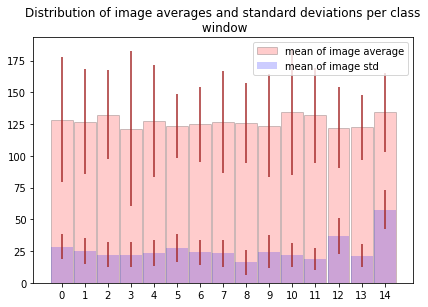

In [ ]:
fig, ax = plt.subplots()
#fig.set_size_inches(15,5)
fig.tight_layout()
ax.set_title("Distribution of image averages and standard deviations per class\n window")
ax.bar(image_eda_table.class_id, image_eda_table.mean_of_image_average,width=0.95,color="red", \
       alpha=0.2,tick_label=range(15),edgecolor="black",yerr=image_eda_table.std_of_image_average,\
       ecolor="brown")
ax.bar(image_eda_table.class_id, image_eda_table.mean_of_image_std,width=0.95,color="blue", \
       alpha=0.2,yerr=image_eda_table.std_of_image_std,ecolor="brown")
ax.legend(["mean of image average","mean of image std"]);
ax.set_xlabel("Class ID")
ax.set_ylabel("Intensity");
fig.savefig("Distribution of image averages and standard deviations per class\n window")

## Plot distribution of image means

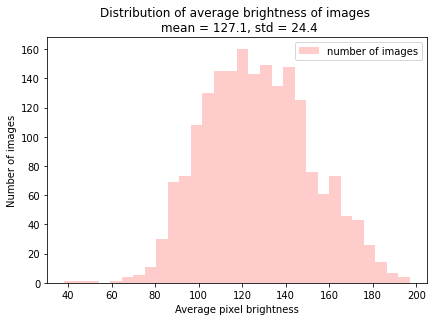

In [ ]:
fig, ax = plt.subplots()
#fig.set_size_inches(15,10)
fig.tight_layout()
mean_of_means_general = np.mean(means_general)
std_of_means_general = np.std(means_general)
ax.hist(means_general,bins=30,color="red",alpha=0.2,)
ax.set_title("Distribution of average brightness of images \n mean = {:.1f}, std = {:.1f}".format(mean_of_means_general,\
                                                                                       std_of_means_general   ))
ax.set_xlabel("Average pixel brightness")
ax.set_ylabel("Number of images");
ax.legend(["number of images"]);
fig.savefig("Distribution of average brightness of images.png")

## Plot distribution of image types

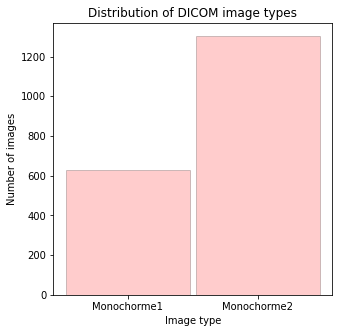

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
photom_interpritation = np.array(photom_interpritation)
photom_interpritation[photom_interpritation=="MONOCHROME1"] = 1
photom_interpritation[photom_interpritation=="MONOCHROME2"] = 2
photom_interpritation = photom_interpritation.astype("int")
num1 = len(photom_interpritation[photom_interpritation == 1])
num2 = len(photom_interpritation[photom_interpritation == 2])
ax.bar([1,2], [num1,num2],width=0.95,color="red", \
       alpha=0.2,tick_label=["Monochorme1","Monochorme2"],edgecolor="black")
ax.set_title("Distribution of DICOM image types")
ax.set_xlabel("Image type")
ax.set_ylabel("Number of images");
fig.savefig("Distribution of DICOM image types.png")

## Plot distribution of patients' gender

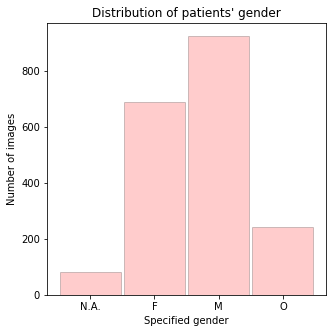

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
patient_gender_ = np.array(patient_gender)
num1 = len(patient_gender_[patient_gender_ == ""])
num2 = len(patient_gender_[patient_gender_ == "F"])
num3 = len(patient_gender_[patient_gender_ == "M"])
num4 = len(patient_gender_[patient_gender_ == "O"])
ax.bar([1,2,3,4], [num1,num2,num3,num4],width=0.95,color="red", \
       alpha=0.2,tick_label=["N.A.","F","M","O"],edgecolor="black")
ax.set_title("Distribution of patients' gender")
ax.set_xlabel("Specified gender")
ax.set_ylabel("Number of images");
fig.savefig("Distribution of patients' gender.png")

## Plot distribution of bit depths

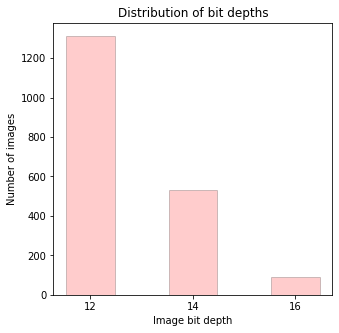

In [ ]:
set(bits_general)
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
bits_general_ = np.array(bits_general)
num1 = len(bits_general_[bits_general_ == 12])
num2 = len(bits_general_[bits_general_ == 14])
num3 = len(bits_general_[bits_general_ == 16])
ax.bar([12,14,16], [num1,num2,num3],width=0.95,color="red", \
       alpha=0.2,tick_label=[12,14,16],edgecolor="black")
ax.set_title("Distribution of bit depths")
ax.set_xlabel("Image bit depth")
ax.set_ylabel("Number of images");
fig.savefig("Distribution of bit depths.png")

## Check correlations

In [32]:
photom_interpritation.shape[0]

1934

In [ ]:
visited_imgs = train_df.image_id.unique()
img_names_ = []
for img_name in visited_imgs:
  if ((img_name not in img_names_) and (len(img_names_) < 1934)):
    img_names_.append(img_name)
img_names_ = np.array(img_names_)

In [58]:
corr_arr = []
for index, img_name in enumerate(img_names_):
  im_df = train_df.loc[train_df.image_id == img_name]
  for i in range(len(im_df)):
    cl_id = im_df.class_id.iloc[i]
    rad_id = int(im_df.rad_id.iloc[i][1:])
    cell = [cl_id,rad_id, photom_interpritation[index], patient_gender[index],\
            bits_general[index]]
    corr_arr.append(cell)
corr_arr = pd.DataFrame(corr_arr, columns=['class_id','rad_id', 'photom_interpritation', \
                                           'patient_gender','bits_general'])
corr_arr.head()

,class_id,rad_id,photom_interpritation,patient_gender,bits_general
0,14,11,MONOCHROME1,F,12
1,14,15,MONOCHROME1,F,12
2,14,16,MONOCHROME1,F,12
3,14,7,MONOCHROME1,M,12
4,14,13,MONOCHROME1,M,12


#### encode values, replace()

In [59]:
to_replace = {"photom_interpritation":     {"MONOCHROME1": 1, "MONOCHROME2": 2},
                "patient_gender": {"": 0, "F": 1, "M": 2, "O": 3}}
corr_arr = corr_arr.replace(to_replace)
corr_arr.photom_interpritation.value_counts()

2    8797
1    4344
Name: photom_interpritation, dtype: int64

In [60]:
corr_arr.patient_gender.value_counts()

2    6428
1    4529
3    1743
0     441
Name: patient_gender, dtype: int64

#### find correlations

In [61]:
corr_arr.corr()

,class_id,rad_id,photom_interpritation,patient_gender,bits_general
class_id,1.000000,-0.137361,0.001096,-0.003993,0.003707
rad_id,-0.137361,1.000000,-0.009324,0.005649,0.010912
photom_interpritation,0.001096,-0.009324,1.000000,-0.025583,0.403202
patient_gender,-0.003993,0.005649,-0.025583,1.000000,-0.041336
bits_general,0.003707,0.010912,0.403202,-0.041336,1.000000


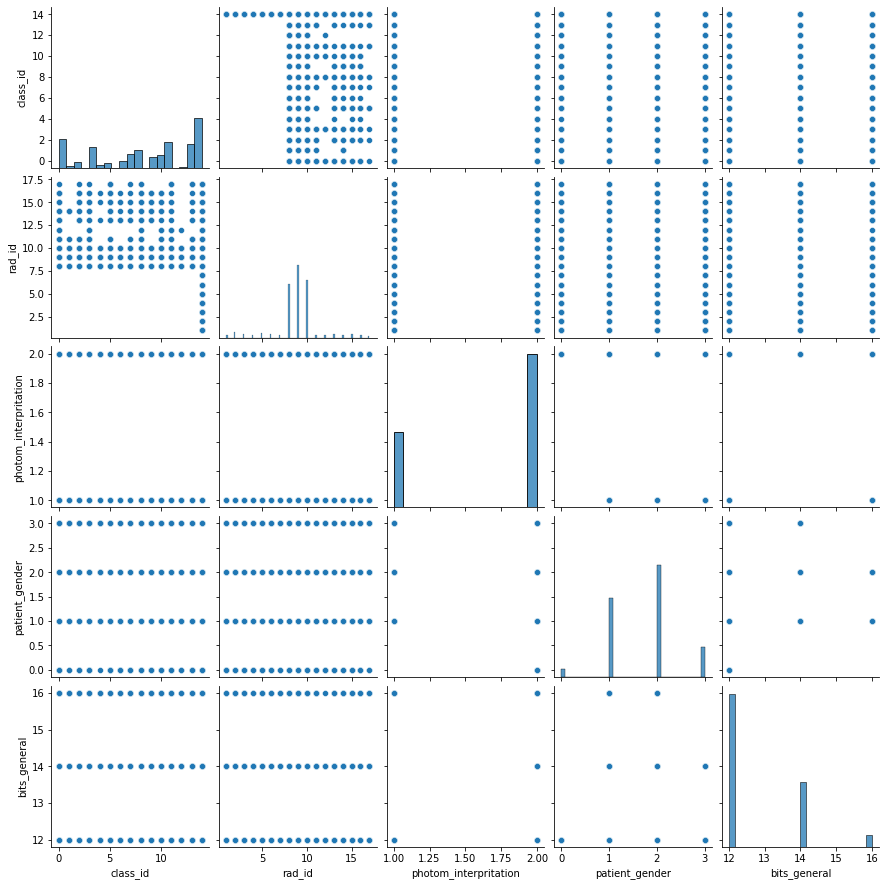

In [65]:
import seaborn as sns

sns.pairplot(corr_arr)

In [ ]:
print(train_df.loc[train_df.rad_id == 'R1'].class_id.value_counts())
print(train_df.loc[train_df.rad_id == 'R2'].class_id.value_counts())
print(train_df.loc[train_df.rad_id == 'R3'].class_id.value_counts())
print(train_df.loc[train_df.rad_id == 'R4'].class_id.value_counts())
print(train_df.loc[train_df.rad_id == 'R5'].class_id.value_counts())
print(train_df.loc[train_df.rad_id == 'R6'].class_id.value_counts())
print(train_df.loc[train_df.rad_id == 'R7'].class_id.value_counts())
print(train_df.loc[train_df.rad_id == 'R8'].class_id.value_counts())

## OTHER

### save arrays

In [ ]:
means_np = np.ones((15,200))
stds_np = np.ones((15,200))
for i in range(15):
  for j in range(len(means[i])):
    means_np[i,j] = means[i][j]
    stds_np[i,j] = stds[i][j]

np.save("/content/drive/MyDrive/VinBigData/means.npy",np.array(means_np))
np.save("/content/drive/MyDrive/VinBigData/stds.npy",np.array(stds_np))
np.save("/content/drive/MyDrive/VinBigData/photom_interpritation.npy",np.array(photom_interpritation))
np.save("/content/drive/MyDrive/VinBigData/patient_gender.npy",np.array(patient_gender))
np.save("/content/drive/MyDrive/VinBigData/bits_general.npy",np.array(bits_general))
np.save("/content/drive/MyDrive/VinBigData/means_general.npy",np.array(means_general))
np.save("/content/drive/MyDrive/VinBigData/stds_general.npy",np.array(stds_general))

### load arrays

In [30]:
import numpy as np

means = np.load("/content/drive/MyDrive/VinBigData/means.npy")
stds = np.load("/content/drive/MyDrive/VinBigData/stds.npy")
photom_interpritation = np.load("/content/drive/MyDrive/VinBigData/photom_interpritation.npy")
patient_gender = np.load("/content/drive/MyDrive/VinBigData/patient_gender.npy")
means_general = np.load("/content/drive/MyDrive/VinBigData/means_general.npy")
stds_general = np.load("/content/drive/MyDrive/VinBigData/stds_general.npy")
bits_general = np.load("/content/drive/MyDrive/VinBigData/bits_general.npy")

### check monochrome images


In [28]:
img_names = train_df.image_id.unique()
i = 0
for img_name in img_names:
  ds=dicom.read_file("/content/drive/MyDrive/VinBigData/train_data/"+img_name+".dicom")
  if (ds.PhotometricInterpretation == 'MONOCHROME2'):
    i += 1
    im = ds.pixel_array
    if (i==5):
      break;
  print(img_name) 

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


50a418190bc3fb1ef1633bf9678929b3
21a10246a5ec7af151081d0cd6d65dc9
9a5094b2563a1ef3ff50dc5c7ff71345
051132a778e61a86eb147c7c6f564dfe
063319de25ce7edb9b1c6b8881290140
1c32170b4af4ce1a3030eb8167753b06


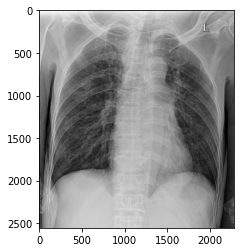

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(im,cmap='gray') 
# 'MONOCHROME2': black lungs, white body
# 'MONOCHROME1': white lungs, black body

# Part 3

## create array holding the number of times classes appear on the same image

In [ ]:
import numpy as np

number_of_classes = len(set(train_df.class_id))
table = np.zeros((number_of_classes,number_of_classes))
grouped = train_df.loc[:,["image_id","class_id","rad_id"]].groupby('image_id')
for idx, group in grouped:
  class_group = group.groupby(["class_id"])
  classes_appeared_once = []
  for idx_cl_id, group_cl_id in class_group:
    unique, counts = np.unique(group_cl_id.rad_id, return_counts=True)
    if np.max(counts) == 1:
      classes_appeared_once.append(idx_cl_id)
  class_group_ind = class_group.count().index
  mesh = np.array(np.meshgrid(class_group_ind, class_group_ind))
  combinations = mesh.T.reshape(-1, 2)
  table[combinations[:,0],combinations[:,1]] += 1
  table[classes_appeared_once,classes_appeared_once] -= 1 

# calculate % #
classes_count = [len(train_df.loc[train_df.class_id == i]) for i in range(number_of_classes)]
for i in range(number_of_classes):
  table[i,:] = table[i,:]/(classes_count[i]) * 100

## plot heatmap

the cell on intersection appends by +1 only if:
- for i != j: both classes exist in specific image
- for i == j: at least one radiologist reported precense of a class twice or more in the same image
- value in a cell is a percentage of the number of times classes exist together relatively to the row class

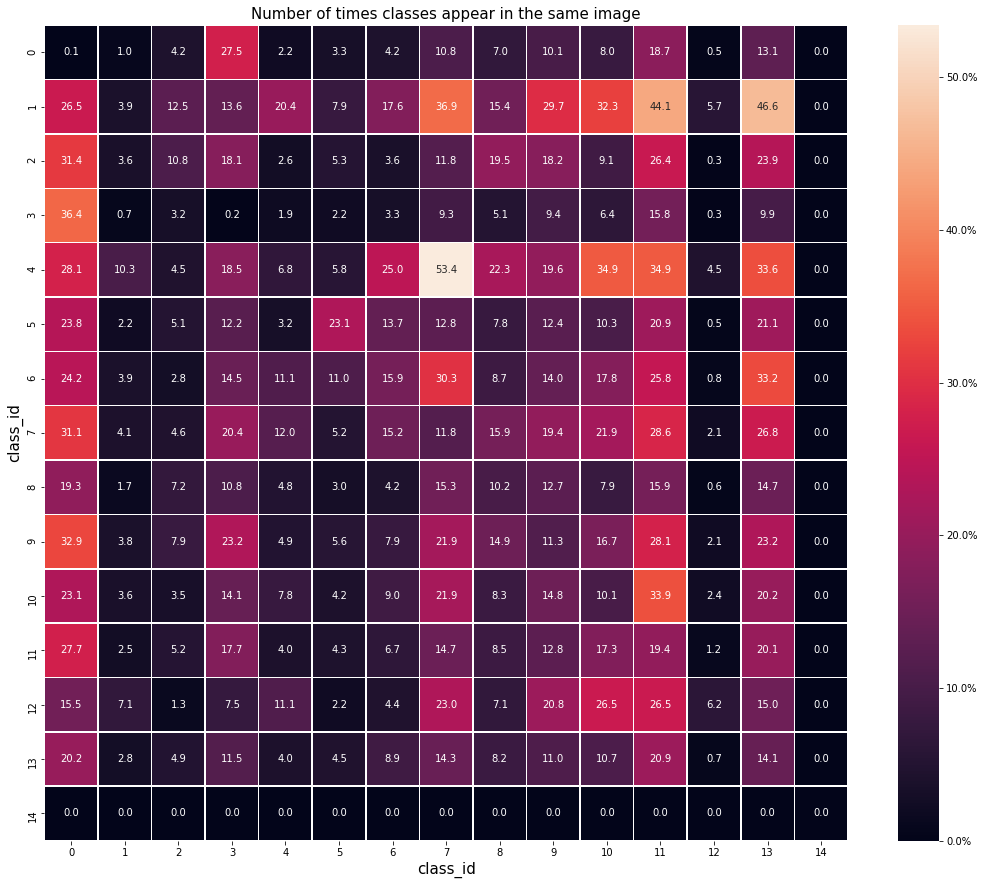

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,15)) 
ax = sns.heatmap(table, annot=True, linewidths=.5, cbar_kws={'format': '%.1f%%'}, fmt='.1f')
ax.set_title("Number of times classes appear in the same image", fontsize=15)
ax.set_xlabel('class_id', fontsize = 15)
ax.set_ylabel('class_id', fontsize = 15)
fig.savefig("Number of times classes appear in the same image.png")